In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv
/kaggle/input/masksforwordclouds/twitter_mask2.png
/kaggle/input/masksforwordclouds/twitter_mask4.jpg
/kaggle/input/masksforwordclouds/twitter_mask3.jpg
/kaggle/input/masksforwordclouds/book-logo-1.jpg
/kaggle/input/masksforwordclouds/twitter_mask.png
/kaggle/input/masksforwordclouds/wordcloud-man.png
/kaggle/input/masksforwordclouds/twitter_mask3.png


# Importing Libraries

In [2]:
from plotly import graph_objs as go
import plotly.express as px
import re
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline
import nltk

from PIL import Image
from wordcloud import WordCloud

In [3]:
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

# Importing Data

In [4]:
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding="latin-1")

df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']

df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.describe()

,target,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


# EDA

In [6]:
df['words_count'] = df['message'].apply(lambda x: len(x.split(' ')))
df['message_len'] = df['message'].apply(len)
df.head()

,target,message,words_count,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20,111
1,ham,Ok lar... Joking wif u oni...,6,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155
3,ham,U dun say so early hor... U c already then say...,11,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61


In [7]:
print(max(df["words_count"]))
print(max(df["message_len"]))

171
910


In [8]:
df.describe()

,words_count,message_len
count,5572.000000,5572.000000
mean,15.606784,80.118808
std,11.422465,59.690841
min,1.000000,2.000000
25%,7.000000,36.000000
50%,12.000000,61.000000
75%,23.000000,121.000000
max,171.000000,910.000000


In [9]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4825,  747])

In [10]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['ham'],
    y=[balance_counts[0]],
    name='ham',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['spam'],
    y=[balance_counts[1]],
    name='spam',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

In [11]:
ham_df = df[df['target'] == 'ham']['words_count'].value_counts().sort_index()
spam_df = df[df['target'] == 'spam']['words_count'].value_counts().sort_index()

In [12]:
print(ham_df.count())
print(ham_df.max())

82
412


In [13]:
print(spam_df.count())
print(spam_df.max())

34
85


In [14]:
concat = pd.concat([ham_df,spam_df], axis=1)
concat

,count,count
words_count,,
1,40,NaN
2,38,2.0
3,76,1.0
4,189,1.0
5,348,3.0
...,...,...
119,1,NaN
121,1,NaN
125,2,NaN


In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x = ham_df.index,
    y = ham_df.values,
    name='ham',
    fill='tozeroy',
    marker_color = primary_blue,
))
fig.add_trace(go.Scatter(
    x=spam_df.index,
    y=spam_df.values,
    name='spam',
    fill='tozeroy',
    marker_color=primary_grey,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.update_xaxes(range=[0, 70])
fig.show()

# Data Pre-Processing

## Cleaning

In [16]:
def clean_text(text):

    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure','c']
    text = str(text).lower()
    text = re.sub('\[.*?\]','', text)
    text = re.sub('https?://\S+|www\.\S+', '',text)
    text = re.sub('<.*?>+','',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n','',text)
    text = re.sub('\w*\d\w*','',text)
    text = ' '.join(word for word in text.split(' ') if word not in STOPWORDS)
    return text

In [17]:
df['clean_message'] = df['message'].apply(clean_text)
df['clean_message_words_count'] = df['clean_message'].apply(lambda x:len(x.split(' ')))
df['clean_message_len'] = df['clean_message'].apply(len) 
df.head()

,target,message,words_count,message_len,clean_message,clean_message_words_count,clean_message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20,111,go jurong point crazy available bugis n great ...,16,82
1,ham,Ok lar... Joking wif u oni...,6,29,ok lar joking wif oni,5,21
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155,free entry wkly comp win fa cup final tkts m...,23,103
3,ham,U dun say so early hor... U c already then say...,11,49,dun say early hor already say,6,29
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61,nah think goes usf lives around though,7,38


In [18]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [19]:
df['clean_message'] = df['clean_message'].apply(stemm_text)
df['stem_clean_message_len'] = df['clean_message'].apply(len)
df.head()

,target,message,words_count,message_len,clean_message,clean_message_words_count,clean_message_len,stem_clean_message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20,111,go jurong point crazi avail bugi n great world...,16,82,76
1,ham,Ok lar... Joking wif u oni...,6,29,ok lar joke wif oni,5,21,19
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155,free entri wkli comp win fa cup final tkts m...,23,103,101
3,ham,U dun say so early hor... U c already then say...,11,49,dun say earli hor alreadi say,6,29,29
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61,nah think goe usf live around though,7,38,36


In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['target'])
df['encoded_target'] = le.transform(df['target'])
df.head()

,target,message,words_count,message_len,clean_message,clean_message_words_count,clean_message_len,stem_clean_message_len,encoded_target
0,ham,"Go until jurong point, crazy.. Available only ...",20,111,go jurong point crazi avail bugi n great world...,16,82,76,0
1,ham,Ok lar... Joking wif u oni...,6,29,ok lar joke wif oni,5,21,19,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155,free entri wkli comp win fa cup final tkts m...,23,103,101,1
3,ham,U dun say so early hor... U c already then say...,11,49,dun say earli hor alreadi say,6,29,29,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61,nah think goe usf live around though,7,38,36,0


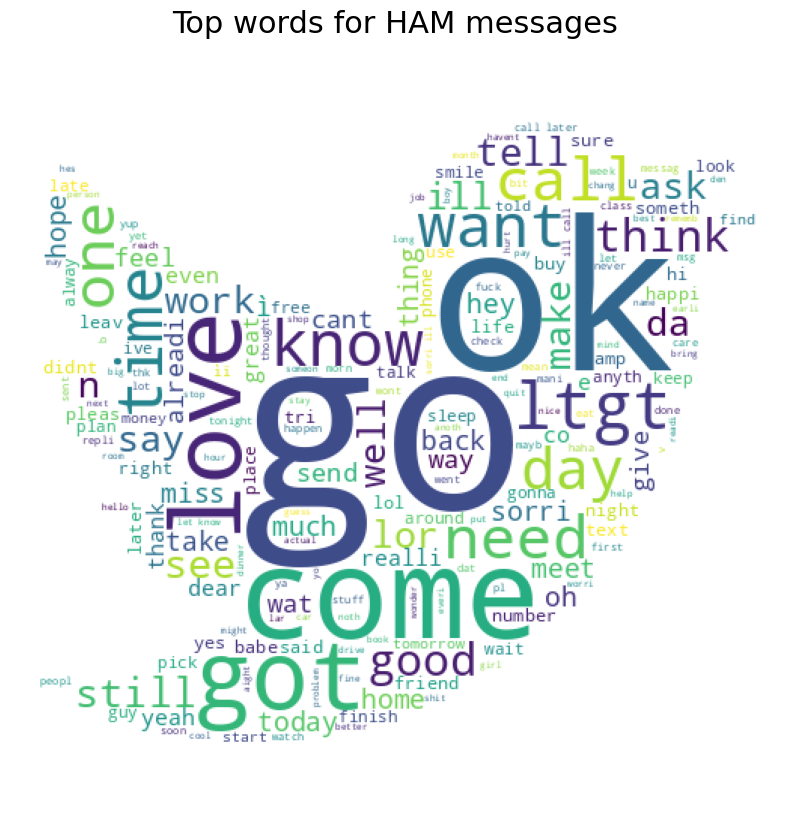

In [21]:
twitter_mask = np.array(Image.open('/kaggle/input/masksforwordclouds/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white',
    max_words = 200,
    mask=twitter_mask
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'ham', 'clean_message']))
plt.figure(figsize=(18,10))
plt.title('Top words for HAM messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

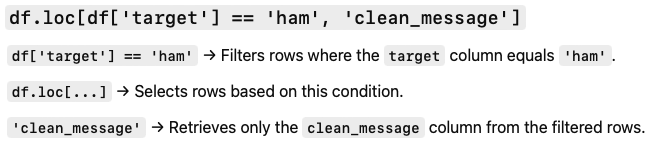

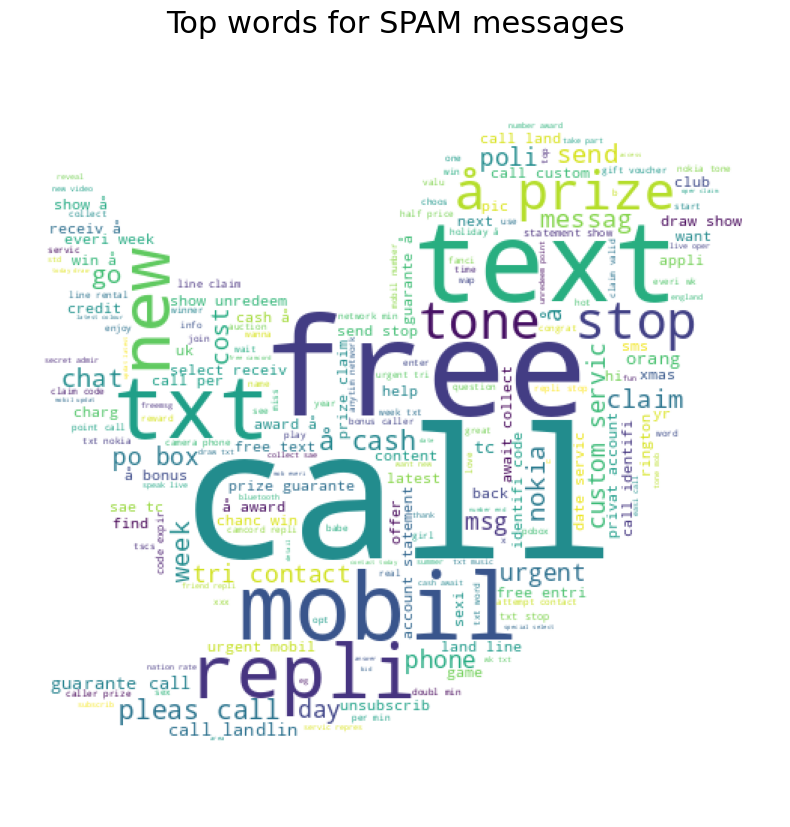

In [22]:
twitter_mask = np.array(Image.open('/kaggle/input/masksforwordclouds/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'spam', 'clean_message']))
plt.figure(figsize=(18,10))
plt.title('Top words for SPAM messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [23]:
x = df['clean_message']
y = df['encoded_target']

In [24]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42)
print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

4179 4179
1393 1393


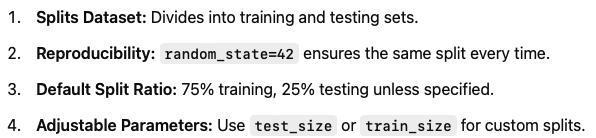

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [26]:
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [27]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<4179x5713 sparse matrix of type '<class 'numpy.float64'>'
	with 32001 stored elements in Compressed Sparse Row format>